In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
CONTRACT_ADDR = "0x7011f3edc7fa43c81440f9f43a6458174113b162"
OUTPUT_DIR = "./image/burst/"


def get_tx(contract_address, internal: bool):
    if internal == False:
        path = f"./data/burst/Tx_external/{contract_address}.csv"
    else:
        path = f"./data/burst/Tx_internal/{contract_address}.csv"

    df = pd.read_csv(path)
    df = df.filter(
        ['timeStamp', 'hash', 'from', 'to', 'value', 'isError'])
    df.value = df.value.astype(float)
    df = df[((~df["to"].isna()) & (~df["from"].isna())) & (df["to"] == CONTRACT_ADDR) | (
        df["from"] == CONTRACT_ADDR) & (df.isError == 0)]
    return df


def merge_tx(df_int, df_ext):
    df_merge = pd.concat([df_int, df_ext], axis=0)
    df_merge.loc[df_merge["from"] ==
                 CONTRACT_ADDR, ["value"]] = -1*df_merge.loc[df_merge["from"] ==
                                                             CONTRACT_ADDR, ["value"]]

    df_merge['out'] = df_merge['value'].apply(
        lambda x: -x if x < 0 else 0)
    df_merge['in'] = df_merge['value'].apply(
        lambda x: x if x >= 0 else 0)
    df_merge = df_merge.sort_values(by=["timeStamp"])
    return df_merge


def get_burst_stats(df_merge):
    df_burst = df_merge.filter(["timeStamp", "value"]).groupby(
        'timeStamp').sum().reset_index()
    df_burst["cum_value"] = df_burst['value'].cumsum(axis=0)
    return df_burst


def visualize_burst(df_burst):
    fig, ax = plt.subplots(figsize=(16, 4))
    sns.lineplot(ax=ax, data=df_burst, x="timeStamp", y="cum_value")
    fig.savefig(f"{OUTPUT_DIR}burst.png")


def get_user_profit_stats(df_merge):
    df_pay = df_merge.groupby("from").sum().reset_index().rename(
        columns={"from": "address", "value": "pay"})
    df_paid = df_merge.groupby("to").sum().reset_index().rename(
        columns={"to": "address", "value": "paid"})

    df_addr = pd.concat([df_pay, df_paid], axis=0).drop(
        columns=["timeStamp", "isError"])

    df_addr = df_addr.groupby("address").sum().reset_index().fillna(0)

    df_addr["p/e"] = (-1*df_addr["paid"])/df_addr["pay"]
    df_addr["profit"] = -1*(df_addr["pay"]+df_addr["paid"])
    return df_addr


def visualize_user_profit_stats(df_addr):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.histplot(ax=ax, data=df_addr, x="p/e", binwidth=0.1)
    fig.savefig(f"{OUTPUT_DIR}pe_hist.png")
    # df_addr[np.isinf(df_addr["p/e"])]
    df_pyramid = df_addr.groupby('p/e').count().reset_index()
    df_pyramid = df_pyramid.rename(columns={
        "address": "count",
    })
    df_pyramid = df_pyramid.filter(["p/e", "count"])
    df_pyramid["p/e"] = round(df_pyramid["p/e"], 1)
    fig, ax = plt.subplots(figsize=(12, 8))
    sns_plot = sns.barplot(ax=ax, data=df_pyramid, x='count',
                           y='p/e', orient='horizontal', ci=None)
    fig = sns_plot.get_figure()
    fig.savefig(f"{OUTPUT_DIR}pe_count.png")

In [2]:
# Get internal and external Tx
df_ext = get_tx(contract_address=CONTRACT_ADDR, internal=False)
df_int = get_tx(contract_address=CONTRACT_ADDR, internal=True)

df_cumsum = merge_tx(df_int, df_ext)


In [3]:
df_cumsum

,timeStamp,hash,from,to,value,isError,out,in
1,1441633419,0x11913ae7330b6457e13ca29d89c21aa145b3ad78982f...,0x0d82cd113dc35ddda93f38166cd5cde8b88e36a1,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
0,1441638649,0xeaa2de2bdcae520cd3ffaa239a55de2f5573b6371e6b...,0xbe1f4a662fbd97cb87fc4b89ab933b42389f550d,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
2,1441641978,0x9296d51e69307c3a41a386882bde774a733e285b64cc...,0x8394a052eb6c32fb9defcaabc12fcbd8fea0b8a8,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
1,1441650473,0x58ee261c4dc03c88c76d30bae2c37a2064f6051c188b...,0x7011f3edc7fa43c81440f9f43a6458174113b162,0x0d82cd113dc35ddda93f38166cd5cde8b88e36a1,-2.700000e+18,0,-2.700000e+18,0.000000e+00
3,1441650473,0x58ee261c4dc03c88c76d30bae2c37a2064f6051c188b...,0xe60d047a7f89348a473eb1b32c27a13cb459d776,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
...,...,...,...,...,...,...,...,...
888,1583866884,0x460ce9f4a279f8088eb37b9caa1da0514edc7b76edd6...,0xab96032f5a7efe3f95622c5b9d98d50f96a91756,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+14,0,0.000000e+00,1.000000e+14
573,1583866884,0x460ce9f4a279f8088eb37b9caa1da0514edc7b76edd6...,0x7011f3edc7fa43c81440f9f43a6458174113b162,0xab96032f5a7efe3f95622c5b9d98d50f96a91756,-1.000000e+14,0,-1.000000e+14,0.000000e+00
889,1609092768,0xb503f1ea842e88cf0f70856aa158383f408a104ffb17...,0x035ac7adc522f1659e6c03972bd37216855478e3,0x7011f3edc7fa43c81440f9f43a6458174113b162,0.000000e+00,0,0.000000e+00,0.000000e+00
890,1609093148,0x7f4ef4fc4a365dacd24cd748718d62c2928283b40681...,0x035ac7adc522f1659e6c03972bd37216855478e3,0x7011f3edc7fa43c81440f9f43a6458174113b162,0.000000e+00,0,0.000000e+00,0.000000e+00


In [4]:
df_cumsum

,timeStamp,hash,from,to,value,isError,out,in
1,1441633419,0x11913ae7330b6457e13ca29d89c21aa145b3ad78982f...,0x0d82cd113dc35ddda93f38166cd5cde8b88e36a1,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
0,1441638649,0xeaa2de2bdcae520cd3ffaa239a55de2f5573b6371e6b...,0xbe1f4a662fbd97cb87fc4b89ab933b42389f550d,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
2,1441641978,0x9296d51e69307c3a41a386882bde774a733e285b64cc...,0x8394a052eb6c32fb9defcaabc12fcbd8fea0b8a8,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
1,1441650473,0x58ee261c4dc03c88c76d30bae2c37a2064f6051c188b...,0x7011f3edc7fa43c81440f9f43a6458174113b162,0x0d82cd113dc35ddda93f38166cd5cde8b88e36a1,-2.700000e+18,0,-2.700000e+18,0.000000e+00
3,1441650473,0x58ee261c4dc03c88c76d30bae2c37a2064f6051c188b...,0xe60d047a7f89348a473eb1b32c27a13cb459d776,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
...,...,...,...,...,...,...,...,...
888,1583866884,0x460ce9f4a279f8088eb37b9caa1da0514edc7b76edd6...,0xab96032f5a7efe3f95622c5b9d98d50f96a91756,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+14,0,0.000000e+00,1.000000e+14
573,1583866884,0x460ce9f4a279f8088eb37b9caa1da0514edc7b76edd6...,0x7011f3edc7fa43c81440f9f43a6458174113b162,0xab96032f5a7efe3f95622c5b9d98d50f96a91756,-1.000000e+14,0,-1.000000e+14,0.000000e+00
889,1609092768,0xb503f1ea842e88cf0f70856aa158383f408a104ffb17...,0x035ac7adc522f1659e6c03972bd37216855478e3,0x7011f3edc7fa43c81440f9f43a6458174113b162,0.000000e+00,0,0.000000e+00,0.000000e+00
890,1609093148,0x7f4ef4fc4a365dacd24cd748718d62c2928283b40681...,0x035ac7adc522f1659e6c03972bd37216855478e3,0x7011f3edc7fa43c81440f9f43a6458174113b162,0.000000e+00,0,0.000000e+00,0.000000e+00


In [5]:
df_cumsum.value.sum()


1.7530605005777777e+20

In [6]:
df_cumsum = df_cumsum.sort_values(by='timeStamp')
df_cumsum = df_cumsum.fillna(0)
# df_cumsum = df_cumsum.dropna()

In [7]:
df_cumsum

,timeStamp,hash,from,to,value,isError,out,in
1,1441633419,0x11913ae7330b6457e13ca29d89c21aa145b3ad78982f...,0x0d82cd113dc35ddda93f38166cd5cde8b88e36a1,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
0,1441638649,0xeaa2de2bdcae520cd3ffaa239a55de2f5573b6371e6b...,0xbe1f4a662fbd97cb87fc4b89ab933b42389f550d,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
2,1441641978,0x9296d51e69307c3a41a386882bde774a733e285b64cc...,0x8394a052eb6c32fb9defcaabc12fcbd8fea0b8a8,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
1,1441650473,0x58ee261c4dc03c88c76d30bae2c37a2064f6051c188b...,0x7011f3edc7fa43c81440f9f43a6458174113b162,0x0d82cd113dc35ddda93f38166cd5cde8b88e36a1,-2.700000e+18,0,-2.700000e+18,0.000000e+00
3,1441650473,0x58ee261c4dc03c88c76d30bae2c37a2064f6051c188b...,0xe60d047a7f89348a473eb1b32c27a13cb459d776,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+18,0,0.000000e+00,1.000000e+18
...,...,...,...,...,...,...,...,...
888,1583866884,0x460ce9f4a279f8088eb37b9caa1da0514edc7b76edd6...,0xab96032f5a7efe3f95622c5b9d98d50f96a91756,0x7011f3edc7fa43c81440f9f43a6458174113b162,1.000000e+14,0,0.000000e+00,1.000000e+14
573,1583866884,0x460ce9f4a279f8088eb37b9caa1da0514edc7b76edd6...,0x7011f3edc7fa43c81440f9f43a6458174113b162,0xab96032f5a7efe3f95622c5b9d98d50f96a91756,-1.000000e+14,0,-1.000000e+14,0.000000e+00
889,1609092768,0xb503f1ea842e88cf0f70856aa158383f408a104ffb17...,0x035ac7adc522f1659e6c03972bd37216855478e3,0x7011f3edc7fa43c81440f9f43a6458174113b162,0.000000e+00,0,0.000000e+00,0.000000e+00
890,1609093148,0x7f4ef4fc4a365dacd24cd748718d62c2928283b40681...,0x035ac7adc522f1659e6c03972bd37216855478e3,0x7011f3edc7fa43c81440f9f43a6458174113b162,0.000000e+00,0,0.000000e+00,0.000000e+00


In [8]:
df_cumsum = df_cumsum.drop(columns=['hash', 'from', 'to', 'isError'])



In [9]:
df_cumsum.value.sum()

1.7530605005777777e+20

In [10]:
df_cumsum = df_cumsum.groupby(
    'timeStamp').sum().reset_index()
df_cumsum = df_cumsum.sort_values(by='timeStamp')


In [11]:
df_cumsum['cum_value'] = df_cumsum['value'].cumsum(axis=0)
df_cumsum['out'] = df_cumsum['out'].cumsum(axis=0)
df_cumsum['in'] = df_cumsum['in'].cumsum(axis=0)


In [12]:
df_cumsum['out/in'] = df_cumsum['out']/df_cumsum['in']


In [13]:
df_cumsum


,timeStamp,value,out,in,cum_value,out/in
0,1441633419,1.000000e+18,0.000000e+00,1.000000e+18,1.000000e+18,0.000000
1,1441638649,1.000000e+18,0.000000e+00,2.000000e+18,2.000000e+18,0.000000
2,1441641978,1.000000e+18,0.000000e+00,3.000000e+18,3.000000e+18,0.000000
3,1441650473,-1.700000e+18,-2.700000e+18,4.000000e+18,1.300000e+18,-0.675000
4,1441652513,1.000000e+18,-2.700000e+18,5.000000e+18,2.300000e+18,-0.540000
...,...,...,...,...,...,...
806,1583866231,0.000000e+00,-9.167812e+20,1.092087e+21,1.753061e+20,-0.839476
807,1583866884,0.000000e+00,-9.167813e+20,1.092087e+21,1.753061e+20,-0.839476
808,1609092768,0.000000e+00,-9.167813e+20,1.092087e+21,1.753061e+20,-0.839476
809,1609093148,0.000000e+00,-9.167813e+20,1.092087e+21,1.753061e+20,-0.839476


<AxesSubplot:xlabel='timeStamp', ylabel='out'>

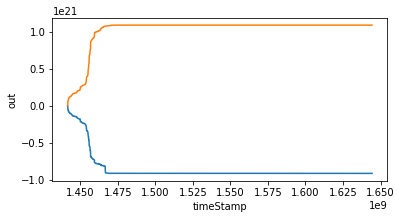

In [15]:
fig, ax = plt.subplots(figsize=(6,3))
sns.lineplot(ax=ax, data=df_cumsum, x='timeStamp', y="out")
sns.lineplot(ax=ax, data=df_cumsum, x='timeStamp', y="in")

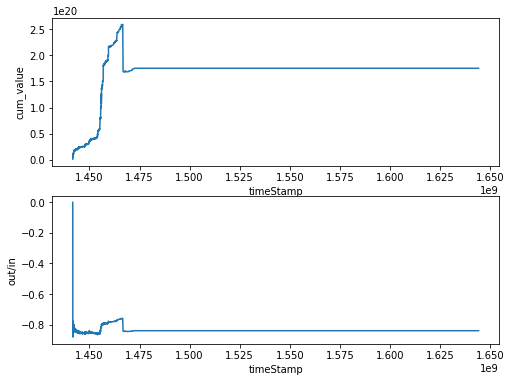

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(8)
fig.set_figheight(6)
sns.lineplot(ax=ax1, data=df_cumsum.head(1000), x='timeStamp', y="cum_value")
sns.lineplot(ax=ax2, data=df_cumsum.head(1000), x='timeStamp', y="out/in")
plt.show()
fig.savefig(f"{OUTPUT_DIR}{CONTRACT_ADDR}.png")


<AxesSubplot:xlabel='timeStamp', ylabel='out'>

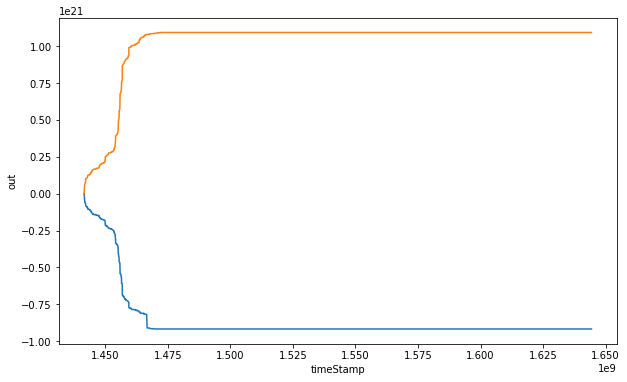

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(ax=ax, data=df_cumsum, x='timeStamp', y="out")
sns.lineplot(ax=ax, data=df_cumsum, x='timeStamp', y="in")


In [ ]:
# Time-series burst
df_burst = get_burst_stats(df_merge)
# visualize_burst(df_burst)
# User profits stats
df_addr = get_user_profit_stats(df_merge)
# visualize_user_profit_stats(df_addr)
# predict burst
print(df_merge.columns)


Index(['timeStamp', 'hash', 'from', 'to', 'value', 'isError', 'cum_value_int',
       'cum_value_ext'],
      dtype='object')
